In [24]:
import pandas as pd
import numpy as np
import os
import spacy

from collections import Counter


import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds

import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score

In [11]:
df = pd.read_csv('./data/Result/dataset.csv')

In [12]:
df.head()

,Text,Class
0,I have heard nothing from the Ambassador about...,Political speech
1,I think it is in the public interest to procee...,Political speech
2,The A-11 aircraft now at Edwards Air force Bas...,Political speech
3,It is one of the most comprehensive bills in t...,Political speech
4,"So long as there remains a man without a job, ...",Political speech


In [16]:
# https://spacy.io/usage
!python -m spacy download en_core_web_sm

                                              0.0/12.8 MB ? eta -:--:--
     -                                        0.5/12.8 MB 10.0 MB/s eta 0:00:02
     ---                                      1.0/12.8 MB 10.8 MB/s eta 0:00:02
     ----                                     1.6/12.8 MB 11.0 MB/s eta 0:00:02
     ------                                   2.2/12.8 MB 11.5 MB/s eta 0:00:01
     --------                                 2.6/12.8 MB 11.2 MB/s eta 0:00:01
     ---------                                3.2/12.8 MB 11.9 MB/s eta 0:00:01
     -----------                              3.7/12.8 MB 11.2 MB/s eta 0:00:01
     -------------                            4.3/12.8 MB 11.3 MB/s eta 0:00:01
     --------------                           4.8/12.8 MB 11.7 MB/s eta 0:00:01
     ----------------                         5.3/12.8 MB 11.7 MB/s eta 0:00:01
     ------------------                       5.8/12.8 MB 11.7 MB/s eta 0:00:01
     -------------------                      6.

In [17]:
# Load the spacy model
nlp = spacy.load("en_core_web_sm")

In [18]:
class_counts = Counter(df['Class'])
class_counts

Counter({'News': 1001,
         'Blog': 998,
         'Literature': 952,
         'Political speech': 797,
         'Jurisdiction': 780})

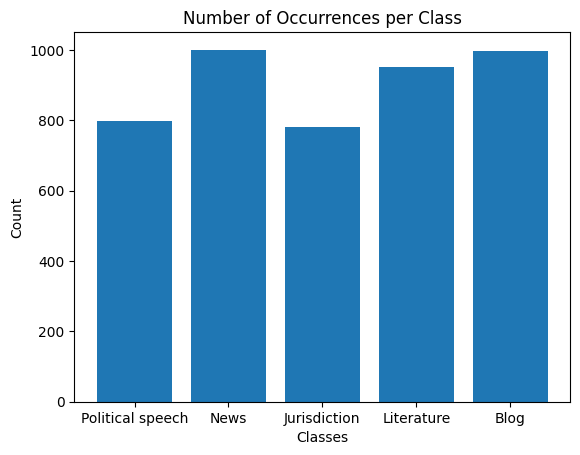

In [19]:
# Show current occurences of the different classes in the dataframe
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Number of Occurrences per Class')
plt.show()

### Balancing the dataset

In [25]:
print(pd.__version__)

2.0.3


In [43]:
# Get minimum number of occurences
min_count = min(class_counts.values())

df_balanced = pd.DataFrame()

# Iterate over all classes
for category in class_counts.keys():
    # Get a random sample of the category, so it gets downsampled
    category_subset = df[df['Class'] == category].sample(n=min_count, random_state=42, ignore_index=True)
    df_balanced =pd.concat([category_subset, df_balanced], ignore_index=True)

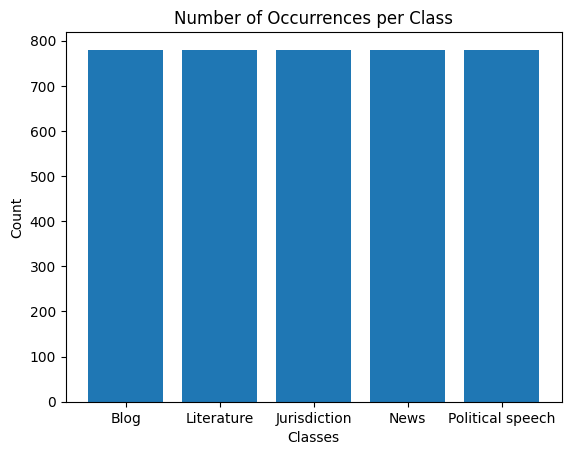

In [44]:
class_counts_balanced = Counter(df_balanced['Class'])

# Show occurences of the different classes in the balanced dataframe
plt.bar(class_counts_balanced.keys(), class_counts_balanced.values())
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Number of Occurrences per Class')
plt.show()

In [45]:
# Dictionary for converting the classes to numeric representation for the usage in the model
classes_mapping = {
    'Literature': 0,
    'News': 1,
    'Blog': 2,
    'Political speech': 3,
    'Jurisdiction': 4
}

df_balanced = df_balanced.replace({"Class": classes_mapping})

In [56]:
df_balanced.head()

,Text,Class
0,"Then she said, 'Can you come in today at 4 p.m...",2
1,"The city of San Francisco, gay capital of Amer...",2
2,After recess was Social Studies for 2 periods....,2
3,The thought of having three to precept and bri...,2
4,"Nobody ever took me aside and said 'hey, you a...",2


## Further Preprocessing

Quelle: https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34

In [57]:
raw_text = df_balanced['Text']
# Change to lowercase
modified_text = [entry.lower() for entry in raw_text]
# Tokenization
modified_text = [word_tokenize(entry) for entry in modified_text]

preprocessed_text = []

# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
for index,entry in enumerate(modified_text):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    preprocessed_text.append(str(Final_words))


LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/english.pickle[0m

  Searched in:
    - 'C:\\Users\\Lukas/nltk_data'
    - 'c:\\Users\\Lukas\\AppData\\Local\\Programs\\Python\\Python311\\nltk_data'
    - 'c:\\Users\\Lukas\\AppData\\Local\\Programs\\Python\\Python311\\share\\nltk_data'
    - 'c:\\Users\\Lukas\\AppData\\Local\\Programs\\Python\\Python311\\lib\\nltk_data'
    - 'C:\\Users\\Lukas\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - ''
**********************************************************************


In [50]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(preprocessed_text, df_balanced['Class'],test_size=0.2, random_state=42)

In [51]:
# Transformation of the text data into vectors, so that the models can process the data
Tfidf_vect = TfidfVectorizer()
Tfidf_vect.fit(preprocessed_text)
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

## Naive Bayes

Quelle: https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34

In [52]:
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y)*100)

Naive Bayes Accuracy Score ->  90.25641025641026


## SVM Classification

Quelle: https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34

In [54]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  97.3076923076923


## BERT Classification

Quelle: https://towardsdatascience.com/fine-tuning-bert-for-text-classification-54e7df642894

In [47]:
# Get texts and classes of dataframe
text = df_balanced.Text.values
classes = df_balanced.Class.values

In [48]:
# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True
    )

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    # set number of classes to classes in df['Class']
    num_labels = len(df['Class'].unique()),
    output_attentions = False,
    output_hidden_states = False,
)

c:\Users\Lukas\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Lukas\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification

In [49]:
token_id = []
attention_masks = []

def preprocessing(text, tokenizer):

  return tokenizer.encode_plus(
                        text,
                        add_special_tokens = True,
                        max_length = 128,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )


for sample in text:
  encoding_dict = preprocessing(sample, tokenizer)
  token_id.append(encoding_dict['input_ids']) 
  attention_masks.append(encoding_dict['attention_mask'])


token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
classes = torch.tensor(classes)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\Lukas\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [50]:
test_ratio = 0.2

batch_size = 32

# Indices of the train and test splits stratified by labels
train_idx, test_idx = train_test_split(
    np.arange(len(classes)),
    test_size = test_ratio,
    shuffle = True,
    stratify = classes)

# Train and test sets
train_set = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          classes[train_idx])

test_set = TensorDataset(token_id[test_idx], 
                        attention_masks[test_idx], 
                        classes[test_idx])

# Prepare DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

test_dataloader = DataLoader(
            test_set,
            sampler = SequentialSampler(test_set),
            batch_size = batch_size
        )

In [60]:
import torch

if torch.cuda.is_available():
    print("CUDA is available. You can use the GPU.")
else:
    print("CUDA is not available. The code will run on the CPU.")

CUDA is not available. The code will run on the CPU.


In [51]:
optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 2e-5,
                              )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 1

for epoch in range(num_epochs):
    
    # ========== Training ==========
    
    # Set model to training mode
    model.train()
    
    # Tracking variables
    tr_loss = 0
    tr_accuracy = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    avg_loss = tr_loss / nb_tr_steps

    # ========== Evaluation ==========

    # Set model to evaluation mode
    model.eval()

    total_correct = 0
    total_samples = 0

    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            # Forward pass
            eval_output = model(b_input_ids, 
                            token_type_ids = None, 
                            attention_mask = b_input_mask)
            logits = eval_output.logits
            label_ids = b_labels.to('cpu').numpy()
            # Calculate validation metrics

            _, predicted_labels = torch.max(logits, 1)

            total_correct += (predicted_labels == b_labels).sum().item()
            total_samples += b_labels.size(0)

    accuracy = total_correct / total_samples

    print(f"Epoch {epoch+1}:")
    print(f"  Loss: {avg_loss:.4f}")
    print(f"  Test Accuracy: {accuracy:.4f}")

Epoch 1:
  Loss: 0.6179
  Test Accuracy: 0.9564


In [19]:
import pickle
# save the model to disk
filename = './models/finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))